In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
import seaborn as sns

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

import tqdm
from konlpy.tag import Mecab
import pandas as pd
import re

m=Mecab(dicpath='C:/mecab/mecab-ko-dic') # 오류나시면 이부분 지우셔야합니다!


df = pd.read_csv("data.csv")
dic = pd.read_csv('./유의어_dictionary.csv', encoding = 'utf-8')
stop_words = pd.read_csv('C:\project_atm\preprocessing/불용어.csv', encoding = 'utf-8', index_col=None)

## 데이터 불러오기

In [2]:
data = df.loc[:,['기사요약','label','등락률']]

data

,기사요약,label,등락률
0,SK이노베이션이 전기차용 배터리를 중심으로 하는 미래 모빌리티 혁신 기술을 대거 공...,1,-2.33%
1,현대차 코나EV가 테슬라 모델3에 맞서는 전기차 강자로 떠올랐다.,1,-2.07%
2,"LG화학, 전기차배터리가 화학 시황 침체 상쇄하고 남을 것으로 추정",1,-0.96%
3,SK이노베이션은 이번 전시회에서 모빌리티 관련 기술과 제품을 한데 모아 ‘SK 인사...,1,2.05%
4,현대차그룹은 2025년까지 미래 모빌리티 기술과 전략에 총 41조원 규모 투자를 단...,1,-1.69%
...,...,...,...
1463,CATL은 2020년 하반기부터는 중국에서 판매하는 테슬라 모델3에도 배터리 공급을...,0,6.85%
1464,중국 배터리 기업 CATL이 세계 전기차 배터리 시장에서 LG에너지솔루션과 격차를 ...,0,6.85%
1465,"CATL, CATL, 올해 글로벌 전기 자동차 배터리 시장에서 먼저 순위가 있으며 ...",0,6.85%
1466,CATL은 201020 년부터 중국까지 중국에서 판매되는 테슬라 모델에서 배터리를 ...,0,6.85%


## 유의어 대치 전 빈출 단어 확인

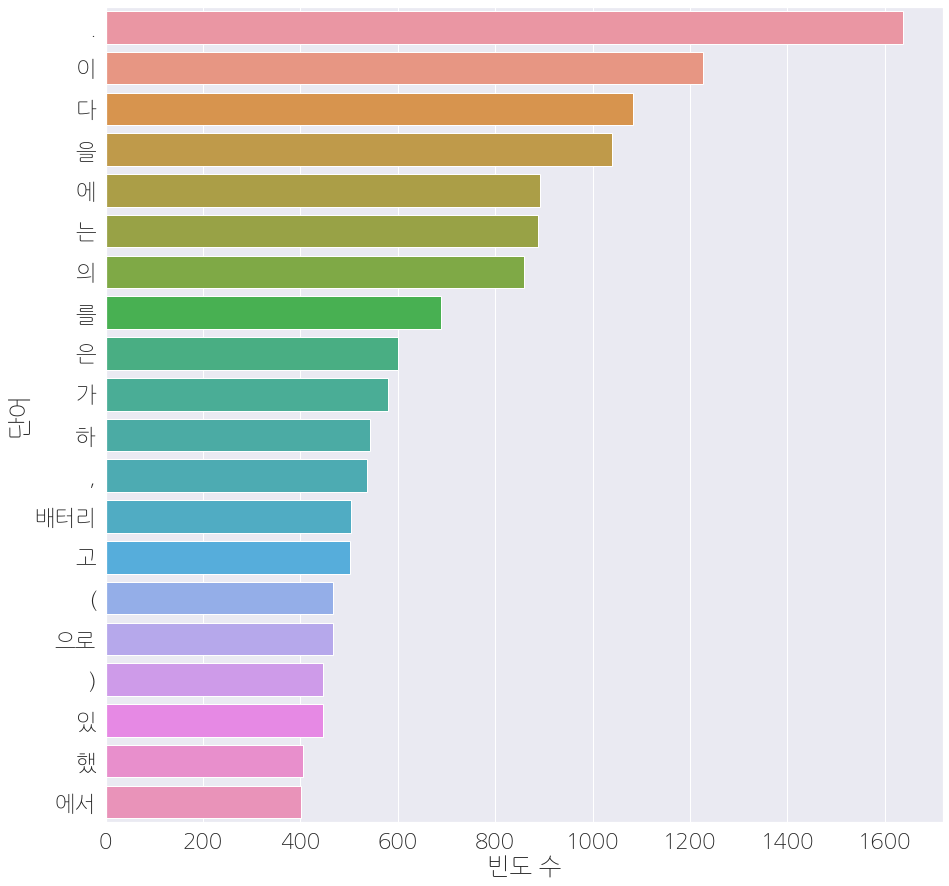

In [3]:
# titles = data['기사요약'].to_list() 
# n_corpus = [] 
# for t in titles: 
#     n_corpus += m.morphs(t)  #mecab에서 명사 추출
    
# count = collections.Counter(n_corpus) 
# most = count.most_common() #빈도 수 순으로 추출 
# x, y= [], [] 
# for word,count in most[:20]: 
#     x.append(word)
#     y.append(count) 

# sns.set(font_scale=2)
# plt.rcParams['font.family'] = 'NanumGothic' 
# plt.figure(figsize=(15,15)) 
# ax = sns.barplot(x=y,y=x)
# ax.set(xlabel = '빈도 수', ylabel = '단어')
# plt.savefig('자연어 전처리 전.png')

## 유의어 대치 및 정규화

In [8]:
stripping = re.compile('[^ ㄱ-ㅣ가-힣+]') # 숫자, 영어제거
for x in range(data['기사요약'].shape[0]):
    for i in range(dic.shape[0]):
        data['기사요약'][x] = re.sub(dic['values'][i], dic['key'][i], data['기사요약'][x])
        
    data['기사요약'][x] = data['기사요약'][x].replace(" ","")
    data['기사요약'][x] = stripping.sub('',data['기사요약'][x])
data['기사요약']

C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


0       에스케이이노베이션이전기차배터리를중심으로하는모빌리티이노베이션기술을대거공개했다자사뿐아니...
1                               현대차코나이브이가모델에맞서는전기차강자로떠올랐다
2                            엘지화학전기차배터리가화학시황침체상쇄하고남을것으로추정
3       에스케이이노베이션은이번전시회에서모빌리티관련기술과제품을한데모아에스케이인사이드라는캐치프...
4                         현대차그룹은년까지모빌리티기술과전략에총조원규모투자를단행한다
                              ...                        
1463                   중국기업은년하반기부터는중국에서판매하는모델에도배터리공급을시작했다
1464    중국배터리기업중국기업이세계전기차배터리시장에서엘지에너지솔루션과격차를벌리며개월연속위자리...
1465     중국기업중국기업올해글로벌전기자동차배터리시장에서먼저순위가있으며시장에서시장점유율의첫번째장소
1466            중국기업은년부터중국까지중국에서판매되는테슬라모델에서배터리를공급하기시작했습니다
1467    중국배터리공사중국기업은엘지전자전기자동차배터리시장에서엘지에너지솔루션및격차를유지하고개월...
Name: 기사요약, Length: 1468, dtype: object

## 유의어 대치 및 정규화 후 빈출 단어

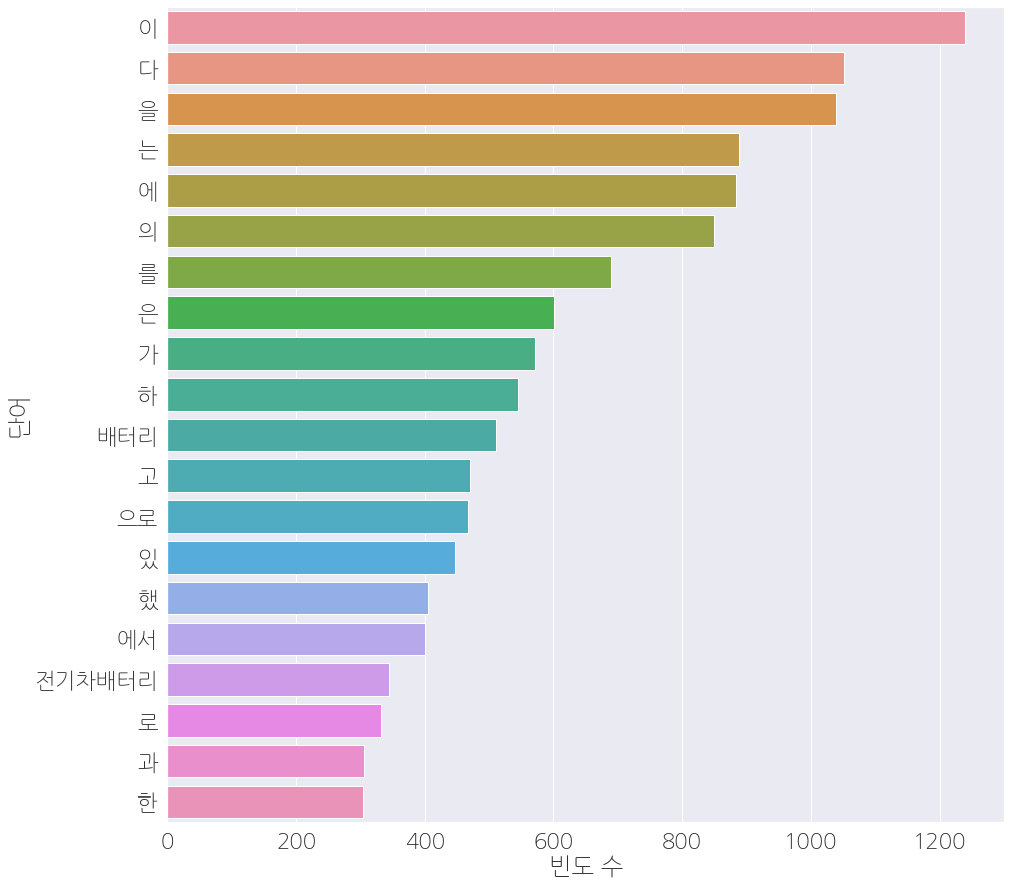

In [5]:
# titles = data['기사요약'].to_list() 
# n_corpus = [] 
# for t in titles: 
#     n_corpus += m.morphs(t)  #mecab에서 명사 추출
    
# count = collections.Counter(n_corpus) 
# most = count.most_common() #빈도 수 순으로 추출 
# x, y= [], [] 
# for word,count in most[:20]: 
#     x.append(word)
#     y.append(count) 

# sns.set(font_scale=2)
# plt.rcParams['font.family'] = 'NanumGothic' 
# plt.figure(figsize=(15,15)) 
# ax = sns.barplot(x=y,y=x)
# ax.set(xlabel = '빈도 수', ylabel = '단어')
# plt.savefig('유의어 전처리 후.png')

## 불용어 제거

In [9]:
def func(text):
    clean = []
    for word in m.pos(text): #어간 추출
        if word[0] not in list(stop_words['stop_words']): #조사, 어미, 구두점 제외 
            clean.append(word[0])
    
    
    return " ".join(clean)

In [10]:
data['tokenized'] = data['기사요약'].apply(lambda x : func(x))
data['tokenized']

0       에스케이 이노베이션 전기차배터리 중심 모빌리티 이노베이션 기술 대거 공개 제품 고객...
1                              현대차 코나이브이 모델 맞서 전기차 강자 떠올랐
2                              엘지화학 전기차배터리 화학 시황 침체 상쇄 추정
3       에스케이이노베이션 전시회 모빌리티 기술 제품 에스케이 인사이드 캐치프레이즈 공개 인...
4                                  현대차그룹 모빌리티 기술 전략 투자 단행
                              ...                        
1463                          중국 기업 년하 반기 중국 판매 모델 배터리 공급
1464       중국 배터리 기업 중국 기업 세계 전기차배터리 시장 엘지에너지솔루션 개월 연속 자리
1465    중국 기업 중국 기업 글로벌 전기자동차 배터리 시장 먼저 순위 시장 시장점유율 첫 ...
1466                         중국 기업 중국 중국 판매 테슬라 모델 배터리 공급
1467    중국 배터리 공사 중국 기업 엘지 전자 전기자동차 배터리 시장 엘지에너지솔루션 유지...
Name: tokenized, Length: 1468, dtype: object

<AxesSubplot:>

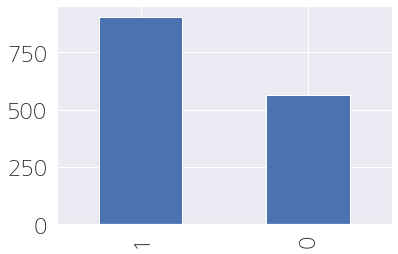

In [8]:
# #레이블의 분포 확인
# data['label'].value_counts().plot(kind = 'bar')

## 자연어 전처리 후

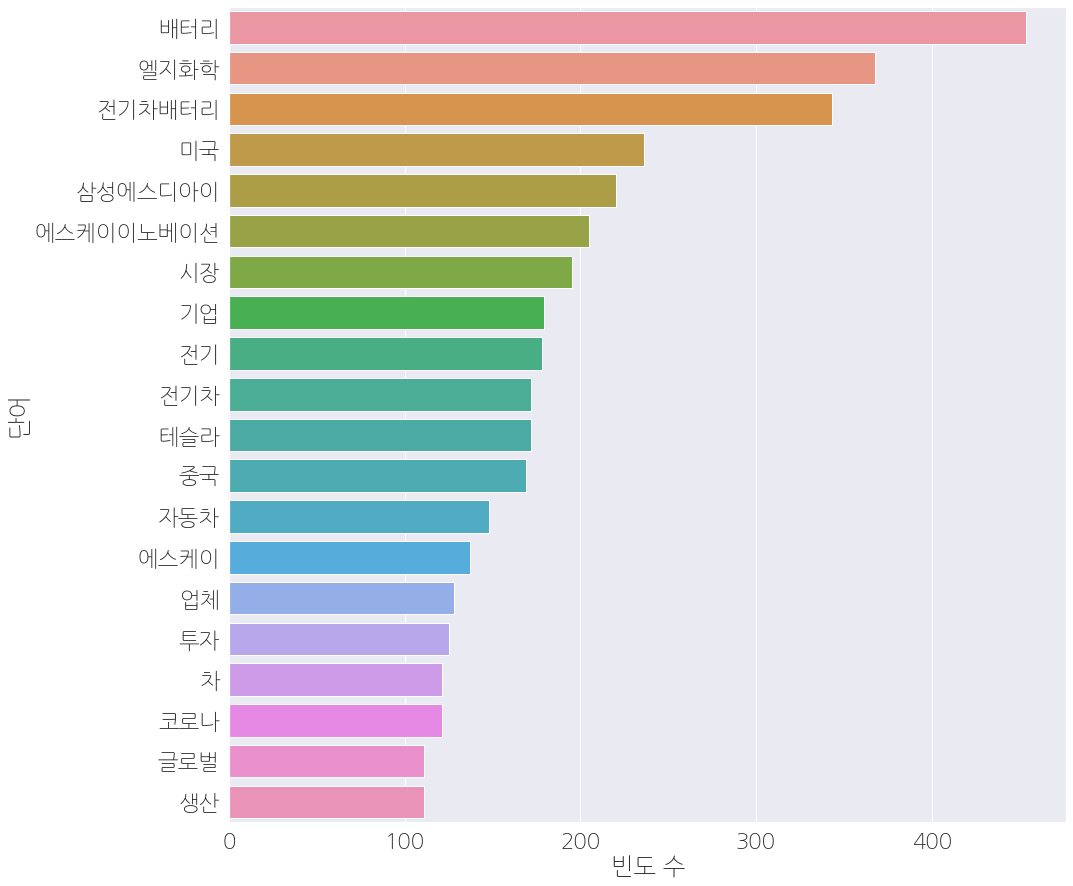

In [11]:
titles = data['tokenized'].to_list() 
n_corpus = [] 
for t in titles: 
    n_corpus += m.morphs(t)  #mecab에서 명사 추출
    
count = collections.Counter(n_corpus) 
most = count.most_common() #빈도 수 순으로 추출 
x, y= [], [] 
for word,count in most[:20]: 
    x.append(word)
    y.append(count) 

sns.set(font_scale=2)
plt.rcParams['font.family'] = 'NanumGothic' 
plt.figure(figsize=(15,15)) 
ax = sns.barplot(x=y,y=x)
ax.set(xlabel = '빈도 수', ylabel = '단어')
plt.savefig('최종_자연어 전처리 후.png')

## 긍부정 확인을 위한 리스트 생성

In [10]:
result = []
for sentence in data['기사요약']:
    temp_X = m.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in list(stop_words['stop_words'])] # 불용어 제거
    result.append(temp_X)

data['확인'] = result
data['확인']

0                       [엘지화학, 전기차배터리, 화학 시황, 침체, 상쇄, 추정]
1            [미국, 전기차, 제조업체, 테슬라, 주가, 사상, 처음, 주당, 달러, 돌파]
2       [세계, 최대, 자산운용사, 미국, 블랙록, 기후변화, 지속, 가능, 성, 투자, ...
3       [중국, 전기차배터리, 업체, 에너지저장장치, 투자, 확대, 분야, 세계, 시장, ...
4       [중국, 전기, 자동차, 배터리, 제조사, 에너지, 저장, 투자, 투자, 촉진, 현...
                              ...                        
1463    [현대자동차그룹, 단행한, 임원, 인사, 전기차, 수소, 연료전지, 로보틱스, 미래...
1464    [현대자동차, 하반기, 임원, 인사, 전기차, 신차, 개발, 주도, 사내, 연구, ...
1465    [내년, 수도권, 우편물류, 운송, 차량, 현대자동차, 중형, 전기트럭, 마이티, ...
1466     [차량, 화재, 리콜, 조치, 코나이브이, 차주, 현대차, 상대, 집단, 소송, 제기]
1467    [특별, 차량, 화재, 회상, 조치, 코나이브이, 현대, 자동차, 집단, 소송, 발...
Name: 확인, Length: 1468, dtype: object

## 긍정 Label 빈출 단어 확인

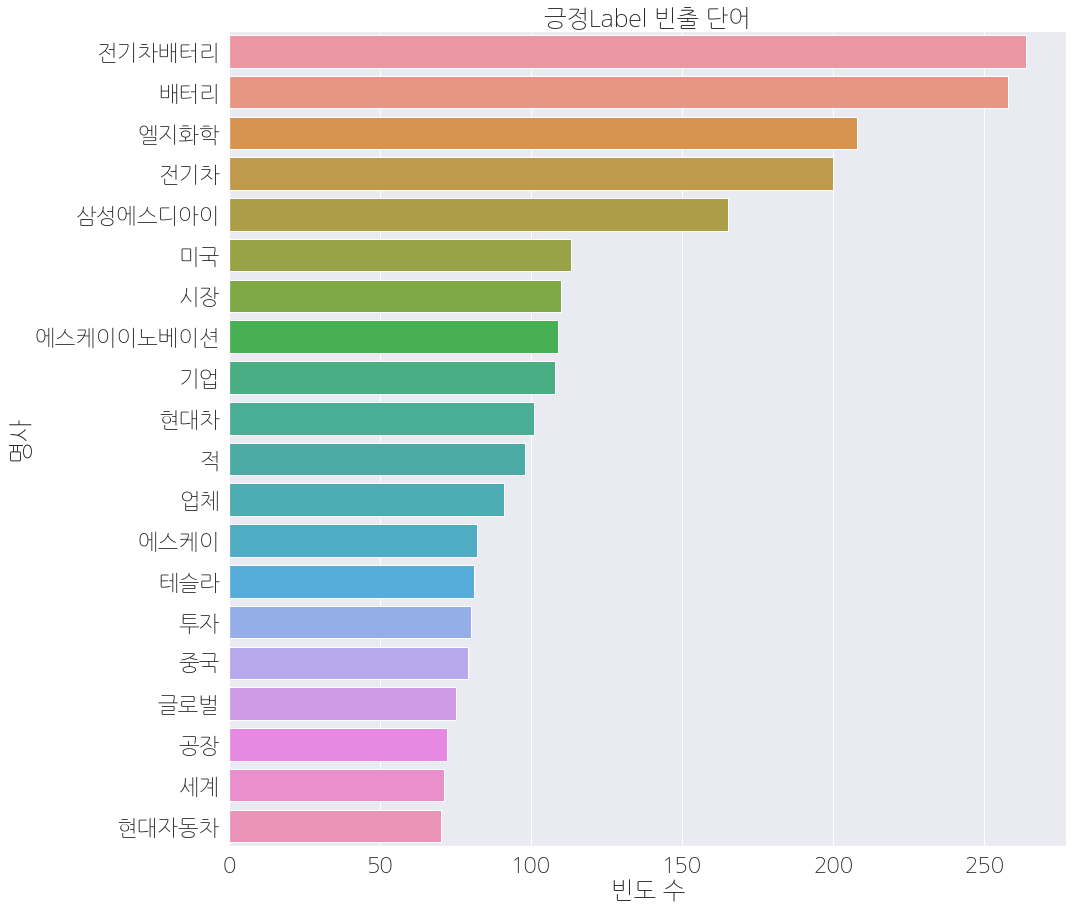

In [11]:
# negative_words = np.hstack(data[data.label == 0]['확인'])
# positive_words = np.hstack(data[data.label == 1]['확인'])

# negative_word_count = Counter(negative_words)
# positive_word_count = Counter(positive_words)

# most_p = positive_word_count.most_common() #빈도 수 순으로 추출 
# most_n = negative_word_count.most_common()

# x, y= [], [] 
# for word,count in most_p[:20]: 
#     x.append(word) 
#     y.append(count)
    
    
    
# plt.rcParams['font.family'] = 'NanumGothic' 
# plt.figure(figsize=(15,15))
# plt.title('긍정Label 빈출 단어')
# ax = sns.barplot(x=y,y=x) 
# ax.set(xlabel = '빈도 수', ylabel = '명사')
# plt.savefig('긍정label 빈출 단어.png')

## 부정 Label 빈출 단어 확인

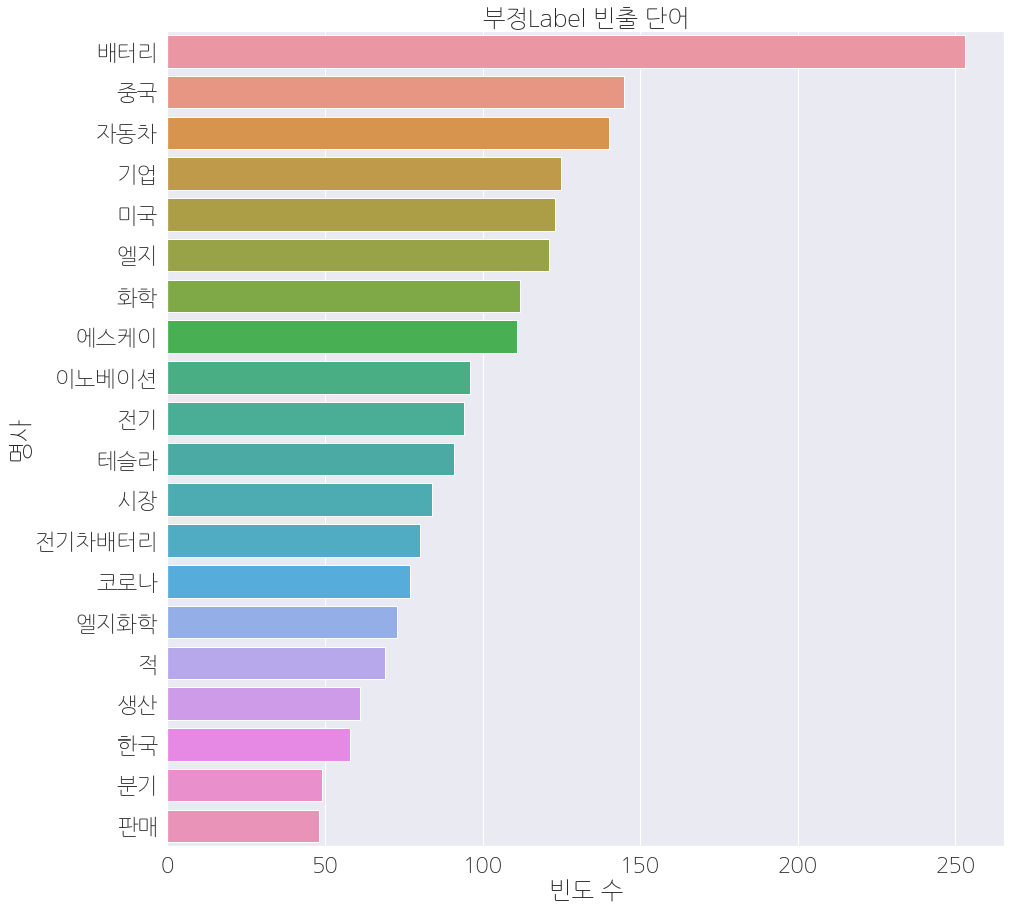

In [12]:
# x, y= [], [] 
# for word,count in most_n[:20]: 
#     x.append(word) 
#     y.append(count)
    
    
    
# plt.rcParams['font.family'] = 'NanumGothic' 
# plt.figure(figsize=(15,15))
# plt.title('부정Label 빈출 단어')
# ax = sns.barplot(x=y,y=x) 
# ax.set(xlabel = '빈도 수', ylabel = '명사')
# plt.savefig('부정label 빈출 단어.png')

In [13]:
# 정수 인코딩
tokenizer =  Tokenizer()
tokenizer.fit_on_texts(data['tokenized'])
encoding_data = tokenizer.texts_to_sequences(data['tokenized'])
encoding_data

[[3, 2, 16, 1845, 329, 1846, 252],
 [5, 4, 330, 13, 35, 238, 131, 1847, 61, 314],
 [25,
  69,
  1244,
  5,
  1848,
  1245,
  152,
  59,
  31,
  21,
  640,
  1246,
  253,
  931,
  1849,
  23,
  2,
  9,
  28,
  3,
  27,
  1,
  36,
  1850,
  23,
  932,
  933,
  1851,
  762,
  93,
  1852,
  763,
  1247,
  105,
  1248],
 [7, 2, 19, 430, 21, 45, 91, 25, 9, 70, 71, 279, 28, 6, 493],
 [7,
  17,
  8,
  1,
  359,
  224,
  934,
  21,
  21,
  1853,
  1249,
  132,
  97,
  9,
  70,
  71,
  239,
  28,
  6,
  493],
 [3, 1250, 1251, 392, 1252, 1250, 177, 23, 331, 16, 62, 331, 177],
 [4,
  641,
  6,
  25,
  360,
  55,
  3,
  254,
  98,
  48,
  161,
  764,
  98,
  124,
  63,
  53,
  393,
  82,
  1253,
  314,
  23,
  331,
  16,
  6,
  546,
  197,
  55],
 [13, 7, 1854, 20, 431, 361, 56, 3, 7, 169, 45],
 [34, 4, 9, 332, 41, 1, 20, 240, 14, 21, 642, 11, 3, 18, 28, 1, 41, 189, 280],
 [34,
  4,
  9,
  332,
  41,
  1,
  20,
  240,
  14,
  21,
  642,
  11,
  3,
  18,
  28,
  1,
  41,
  189,
  280,
  198,
  3,
  

In [14]:
def split_dataset(encode,df):
    X_data = encode
    y_data = data['label']

    # stratify=y_data Stratified 기반 분할, train 데이터의 30%를 평가 데이터 셋으로 사용. (70% 데이터 학습에 사용)
    X_train, X_test, y_train, y_test = \
    train_test_split(X_data, y_data, test_size=0.2) # 필요 시 random_state, 현재 Shuffle 상태
    print('훈련용 리뷰의 개수 :', len(X_train))
    print('테스트용 리뷰의 개수 :', len(X_test))
    
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = split_dataset(encoding_data,data, random_state=5)


훈련용 리뷰의 개수 : 1174
테스트용 리뷰의 개수 : 294


In [15]:
#등장 횟수가 1회인 단어들은 자연어 처리에서 배제
#이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3439
등장 빈도가 1번 이하인 희귀 단어의 수: 1595
단어 집합에서 희귀 단어의 비율: 46.37976155859261
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.634866689004835


In [16]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1846


기사 최대 길이 : 52
기사 평균 길이 : 14.240204429301533


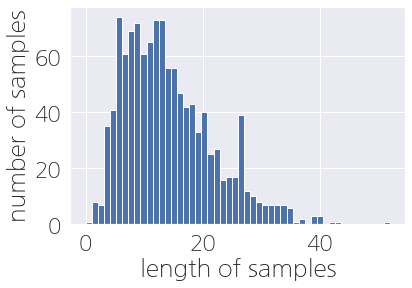

In [17]:
print('기사 최대 길이 :',max(len(l) for l in X_train))
print('기사 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [19]:
#최대 길이가 64이므로 만약 60으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해봅시다.

max_len = 52
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.91482112436117


In [20]:
# 훈련용 리뷰의 99.74%가 40이하의 길이를 가집니다. 훈련용 리뷰를 길이 40으로 패딩하겠습니다.
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 베이스라인 모델 (LightGBM)

In [21]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, confusion_matrix


# 트리개수 400개로 지정
lgbm_wrapper = LGBMClassifier(boosting_type='gbdt', num_leaves=1000, n_estimators=700, learning_rate = 0.3) 



# early stopping 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric='accuracy',
                eval_set = evals, verbose = True)

preds = lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.66001
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.653245
[3]	valid_0's binary_logloss: 0.656246
[4]	valid_0's binary_logloss: 0.651879
[5]	valid_0's binary_logloss: 0.659344
[6]	valid_0's binary_logloss: 0.663673
[7]	valid_0's binary_logloss: 0.67084
[8]	valid_0's binary_logloss: 0.665309
[9]	valid_0's binary_logloss: 0.668438
[10]	valid_0's binary_logloss: 0.671082
[11]	valid_0's binary_logloss: 0.68179
[12]	valid_0's binary_logloss: 0.690063
[13]	valid_0's binary_logloss: 0.685919
[14]	valid_0's binary_logloss: 0.685627
[15]	valid_0's binary_logloss: 0.685916
[16]	valid_0's binary_logloss: 0.67663
[17]	valid_0's binary_logloss: 0.676113
[18]	valid_0's binary_logloss: 0.688546
[19]	valid_0's binary_logloss: 0.692271
[20]	valid_0's binary_logloss: 0.704597
[21]	valid_0's binary_logloss: 0.711282
[22]	valid_0's binary_logloss: 0.714631
[23]	valid_0's binary_logloss: 0.716815
[24]	valid_0's binary_logloss: 

In [22]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC =  roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [23]:
get_clf_eval(y_test, preds)

오차행렬:
 [[ 43  69]
 [ 38 144]]

정확도: 0.6361
정밀도: 0.6761
재현율: 0.7912
F1: 0.7291
AUC: 0.5876


## Bi-LSTM 모델

In [24]:
model = Sequential([Embedding(total_cnt+1, 300, input_length =max_len),
        tf.keras.layers.Bidirectional(LSTM(units = 128, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 128, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 128)),
        Dense(1, activation='sigmoid')    # 결과값이 0~1 이므로 Dense(1)
    ])
    
model.compile(loss= 'binary_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'rmsprop',
              metrics = ['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 500)           1720000   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           644096    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 3,152,833
Trainable params: 3,152,833
Non-trainable params: 0
_________________________________________________________________


In [25]:
vocab_size

1846

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history1 = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=128, validation_split=0.2)

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.5889
Epoch 00001: val_loss improved from inf to 0.58327, saving model to best_model.h5
8/8 [==============================] - 7s 903ms/step - loss: 0.8507 - accuracy: 0.5889 - val_loss: 0.5833 - val_accuracy: 0.7787
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8296
Epoch 00002: val_loss improved from 0.58327 to 0.37638, saving model to best_model.h5
8/8 [==============================] - 6s 797ms/step - loss: 0.4363 - accuracy: 0.8296 - val_loss: 0.3764 - val_accuracy: 0.8170
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9489
Epoch 00003: val_loss did not improve from 0.37638
8/8 [==============================] - 7s 868ms/step - loss: 0.1477 - accuracy: 0.9489 - val_loss: 0.4921 - val_accuracy: 0.8383
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9904
Epoch 00004: val_loss 

In [27]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

10/10 [==============================] - 1s 50ms/step - loss: 0.3837 - accuracy: 0.8299
테스트 정확도: 0.8299


In [28]:
def sentiment_predict(new_sentence):
    stop_words = pd.read_csv('C:\project_atm\preprocessing/불용어.csv', encoding = 'utf-8', index_col=None)
    stripping = re.compile('[^ ㄱ-ㅣ가-힣+]')
    for i in range(dic.shape[0]):
        new_sentence = re.sub(dic['values'][i], dic['key'][i], new_sentence)
    
    new_sentence = stripping.sub('',new_sentence)
    new_sentence = new_sentence.split() # 토큰화
    new_sentence = [word for word in new_sentence if not word in list(stop_words['stop_words'])] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 라벨입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 라벨입니다.".format((1 - score) * 100))

In [29]:
sentiment_predict('중국 기업의 지난해 배터리 관련 투자액이 한국의 7배에 달한 것으로 추정됐다.')
print("기사내용:",'중국 기업의 지난해 배터리 관련 투자액이 한국의 7배에 달한 것으로 추정됐다.')

67.89% 확률로 부정 라벨입니다.
기사내용: 중국 기업의 지난해 배터리 관련 투자액이 한국의 7배에 달한 것으로 추정됐다.


In [30]:
sentiment_predict('미국 국제무역위원회(ITC)가 9일(현지시간) LG화학과 SK이노베이션 간 전기차 배터리 영업비밀 침해 사건에 대한 최종 결정(determination)을 내년 2월 10일로 또다시 연기했다.')
print("기사내용:",'미국 국제무역위원회(ITC)가 9일(현지시간) LG화학과 SK이노베이션 간 전기차 배터리 영업비밀 침해 사건에 대한 최종 결정(determination)을 내년 2월 10일로 또다시 연기했다.')

85.76% 확률로 긍정 라벨입니다.
기사내용: 미국 국제무역위원회(ITC)가 9일(현지시간) LG화학과 SK이노베이션 간 전기차 배터리 영업비밀 침해 사건에 대한 최종 결정(determination)을 내년 2월 10일로 또다시 연기했다.


In [31]:
sentiment_predict("잇따른 K-배터리 화재에 미소짓는 일본과 중국")
print("기사내용:", "잇따른 K-배터리 화재에 미소짓는 일본과 중국")

61.94% 확률로 부정 라벨입니다.
기사내용: 잇따른 K-배터리 화재에 미소짓는 일본과 중국


In [32]:
sentiment_predict("중국기업이 엘지화학을 누르고 점유율 1위를 기록했다")
print("기사내용:", "중국기업이 엘지화학을 누르고 점유율 1위를 기록했다")

90.75% 확률로 긍정 라벨입니다.
기사내용: 중국기업이 엘지화학을 누르고 점유율 1위를 기록했다


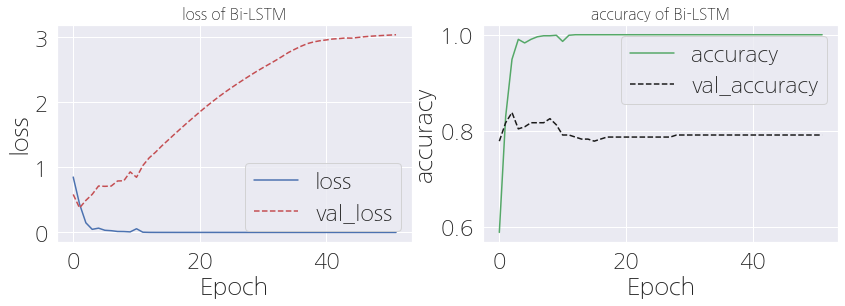

In [33]:
# Bi-LSTM 모델 학습 결과 확인
plt.figure(figsize=(14, 4))
plt.title('Bi-LSTM (model1) ', fontsize= 15)

plt.subplot(1, 2, 1)
plt.title('loss of Bi-LSTM', fontsize= 15)
plt.plot(history1.history['loss'], 'b-', label='loss')
plt.plot(history1.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bi-LSTM', fontsize= 15)
plt.plot(history1.history['accuracy'], 'g-', label='accuracy')
plt.plot(history1.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show
plt.savefig('Bi-LSTM.png')

## simpleRNN

In [34]:
# # Simple RNN 레이어를 사용한 모델 (model1) 정의
# model1 = Sequential([Embedding(total_cnt+1, 500, input_length =max_len),
#         tf.keras.layers.SimpleRNN(units = 128, return_sequences = True),
#         tf.keras.layers.SimpleRNN(units = 128, return_sequences = True),
#         tf.keras.layers.SimpleRNN(units = 128),
#         Dense(1, activation='sigmoid')    # 결과값이 0~4 이므로 Dense(5)
#     ])
    
# model1.compile(loss= 'binary_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
#               optimizer= 'rmsprop',
#               metrics = ['accuracy']) 
# model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 500)           1720000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50, 128)           80512     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50, 128)           32896     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,866,433
Trainable params: 1,866,433
Non-trainable params: 0
_________________________________________________________________


In [35]:
# es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
# mc = ModelCheckpoint('best_model_rnn.h5', monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

In [36]:
# # 모델 실행해보기
# history3 = model1.fit(X_train, y_train, epochs=100, batch_size=128, validation_split= 0.2, callbacks = [es, mc]) 
#   # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
#   # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.8996 - accuracy: 0.4771
Epoch 00001: val_loss improved from inf to 0.71495, saving model to best_model_rnn.h5
8/8 [==============================] - 1s 132ms/step - loss: 0.8996 - accuracy: 0.4771 - val_loss: 0.7150 - val_accuracy: 0.3787
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.6784
Epoch 00002: val_loss improved from 0.71495 to 0.70958, saving model to best_model_rnn.h5
8/8 [==============================] - 1s 105ms/step - loss: 0.5802 - accuracy: 0.6784 - val_loss: 0.7096 - val_accuracy: 0.5574
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9223
Epoch 00003: val_loss did not improve from 0.70958
8/8 [==============================] - 1s 111ms/step - loss: 0.2069 - accuracy: 0.9223 - val_loss: 0.8532 - val_accuracy: 0.5574
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9862
Epoch 00004: v

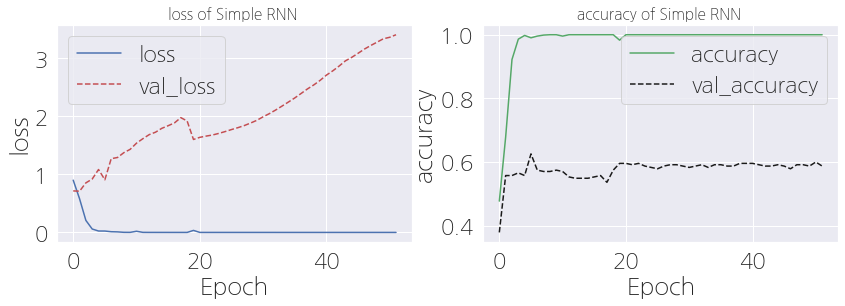

In [37]:
# # Simple RNN 모델 (model1) 학습 결과 확인
# plt.figure(figsize=(14, 4))
# plt.title('Simple RNN (model1) ', fontsize= 15)

# plt.subplot(1, 2, 1)
# plt.title('loss of Simple RNN ', fontsize= 15)
# plt.plot(history3.history['loss'], 'b-', label='loss')
# plt.plot(history3.history['val_loss'],'r--', label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.title('accuracy of Simple RNN ', fontsize= 15)
# plt.plot(history3.history['accuracy'], 'g-', label='accuracy')
# plt.plot(history3.history['val_accuracy'],'k--', label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show
# plt.savefig('Simple RNN.png')

In [38]:
# loaded_model = load_model('best_model_rnn.h5')
# print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

10/10 [==============================] - 0s 10ms/step - loss: 0.7387 - accuracy: 0.5340
테스트 정확도: 0.5340


In [39]:
# sentiment_predict("SK이노베이션이 전기차용 배터리를 중심으로 하는 미래 모빌리티 혁신 기술을 대거 공개했다. 자사 뿐 아니라 자사 제품을 사서 쓰는 고객을 혁신시킨다는 목표를 세우고 이를 'SK인사이드(SK inside)'라고 명명했다.")
# print("기사내용:", "SK이노베이션이 전기차용 배터리를 중심으로 하는 미래 모빌리티 혁신 기술을 대거 공개했다. 자사 뿐 아니라 자사 제품을 사서 쓰는 고객을 혁신시킨다는 목표를 세우고 이를 'SK인사이드(SK inside)'라고 명명했다.")

58.68% 확률로 긍정 라벨입니다.
기사내용: SK이노베이션이 전기차용 배터리를 중심으로 하는 미래 모빌리티 혁신 기술을 대거 공개했다. 자사 뿐 아니라 자사 제품을 사서 쓰는 고객을 혁신시킨다는 목표를 세우고 이를 'SK인사이드(SK inside)'라고 명명했다.


In [40]:
# sentiment_predict('중국 기업의 지난해 배터리 관련 투자액이 한국의 7배에 달한 것으로 추정됐다.')
# print("기사내용:",'중국 기업의 지난해 배터리 관련 투자액이 한국의 7배에 달한 것으로 추정됐다.')

53.35% 확률로 긍정 라벨입니다.
기사내용: 중국 기업의 지난해 배터리 관련 투자액이 한국의 7배에 달한 것으로 추정됐다.


In [41]:
# sentiment_predict('미국 국제무역위원회(ITC)가 9일(현지시간) LG화학과 SK이노베이션 간 전기차 배터리 영업비밀 침해 사건에 대한 최종 결정(determination)을 내년 2월 10일로 또다시 연기했다.')
# print("기사내용:",'미국 국제무역위원회(ITC)가 9일(현지시간) LG화학과 SK이노베이션 간 전기차 배터리 영업비밀 침해 사건에 대한 최종 결정(determination)을 내년 2월 10일로 또다시 연기했다.')

58.88% 확률로 긍정 라벨입니다.
기사내용: 미국 국제무역위원회(ITC)가 9일(현지시간) LG화학과 SK이노베이션 간 전기차 배터리 영업비밀 침해 사건에 대한 최종 결정(determination)을 내년 2월 10일로 또다시 연기했다.


In [42]:
# sentiment_predict("LG에너지솔루션은 다양한 자금조달 방안을 활용해 적기에 투자를 확대할 계획이다. 업계 안팎에서는 대규모 투자 유치를 위해 조만간 상장할 것이란 전망에 무게를 싣고 있다.")
# print("기사내용:",'LG에너지솔루션은 다양한 자금조달 방안을 활용해 적기에 투자를 확대할 계획이다. 업계 안팎에서는 대규모 투자 유치를 위해 조만간 상장할 것이란 전망에 무게를 싣고 있다.')

52.65% 확률로 부정 라벨입니다.
기사내용: LG에너지솔루션은 다양한 자금조달 방안을 활용해 적기에 투자를 확대할 계획이다. 업계 안팎에서는 대규모 투자 유치를 위해 조만간 상장할 것이란 전망에 무게를 싣고 있다.


In [43]:
# sentiment_predict("현대차, 반도체 칩 공급난에 8월 미국 판매 4% 감소")
# print("기사내용:", "현대차, 반도체 칩 공급난에 8월 미국 판매 4% 감소")

53.75% 확률로 긍정 라벨입니다.
기사내용: 현대차, 반도체 칩 공급난에 8월 미국 판매 4% 감소


In [44]:
# sentiment_predict("이 여파로 8월 총판매량이 감소한 데 이어 일반 고객을 대상으로 하는 소매 판매(5만1천950대)도 7% 하락했다.")
# print("기사내용:", "이 여파로 8월 총판매량이 감소한 데 이어 일반 고객을 대상으로 하는 소매 판매(5만1천950대)도 7% 하락했다.")

51.98% 확률로 부정 라벨입니다.
기사내용: 이 여파로 8월 총판매량이 감소한 데 이어 일반 고객을 대상으로 하는 소매 판매(5만1천950대)도 7% 하락했다.


## lstm

In [45]:

# model2 = Sequential([Embedding(total_cnt+1, 500, input_length =max_len),
#         tf.keras.layers.LSTM(units = 128, return_sequences = True),
#         tf.keras.layers.LSTM(units = 128, return_sequences = True),
#         tf.keras.layers.LSTM(units = 128),
#         Dense(1, activation='sigmoid')    # 결과값이 0~4 이므로 Dense(5)
#     ])
    
# model2.compile(loss= 'binary_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
#               optimizer= 'rmsprop',
#               metrics = ['accuracy']) 
# model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 500)           1720000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 128)           322048    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 128)           131584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,305,345
Trainable params: 2,305,345
Non-trainable params: 0
_________________________________________________________________


In [46]:
# # 모델 실행해보기
# history2 = model2.fit(X_train, y_train, epochs=100, batch_size=128, validation_split= 0.2, callbacks = [es, mc]) 
#   # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
#   # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.7821 - accuracy: 0.5964
Epoch 00001: val_loss improved from 0.70958 to 0.66096, saving model to best_model_rnn.h5
8/8 [==============================] - 4s 446ms/step - loss: 0.7821 - accuracy: 0.5964 - val_loss: 0.6610 - val_accuracy: 0.6511
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.7199
Epoch 00002: val_loss improved from 0.66096 to 0.49396, saving model to best_model_rnn.h5
8/8 [==============================] - 3s 335ms/step - loss: 0.6065 - accuracy: 0.7199 - val_loss: 0.4940 - val_accuracy: 0.8255
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8701
Epoch 00003: val_loss improved from 0.49396 to 0.37135, saving model to best_model_rnn.h5
8/8 [==============================] - 3s 334ms/step - loss: 0.3380 - accuracy: 0.8701 - val_loss: 0.3714 - val_accuracy: 0.8511
Epoch 4/100
8/8 [==============================] - ETA: 0s - los

8/8 [==============================] - ETA: 0s - loss: 1.1040e-05 - accuracy: 1.0000
Epoch 00030: val_loss did not improve from 0.37041
8/8 [==============================] - 3s 353ms/step - loss: 1.1040e-05 - accuracy: 1.0000 - val_loss: 1.4261 - val_accuracy: 0.8468
Epoch 31/100
8/8 [==============================] - ETA: 0s - loss: 5.0957e-06 - accuracy: 1.0000
Epoch 00031: val_loss did not improve from 0.37041
8/8 [==============================] - 3s 339ms/step - loss: 5.0957e-06 - accuracy: 1.0000 - val_loss: 1.4682 - val_accuracy: 0.8468
Epoch 32/100
8/8 [==============================] - ETA: 0s - loss: 3.7537e-06 - accuracy: 1.0000
Epoch 00032: val_loss did not improve from 0.37041
8/8 [==============================] - 3s 337ms/step - loss: 3.7537e-06 - accuracy: 1.0000 - val_loss: 1.4979 - val_accuracy: 0.8468
Epoch 33/100
8/8 [==============================] - ETA: 0s - loss: 2.8508e-06 - accuracy: 1.0000
Epoch 00033: val_loss did not improve from 0.37041
8/8 [=============

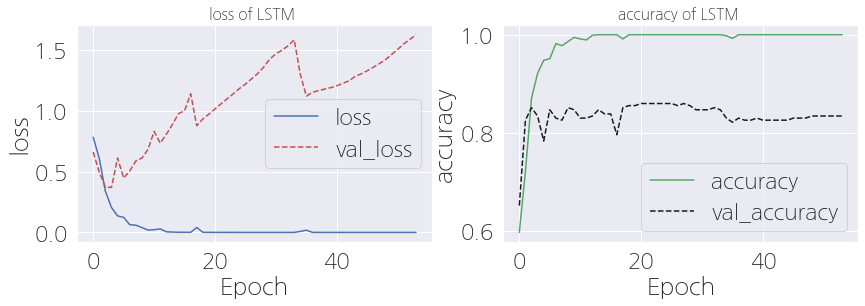

In [47]:
# # 모델 학습 결과 확인
# plt.figure(figsize=(14, 4))

# plt.subplot(1, 2, 1)
# plt.title('loss of LSTM ', fontsize= 15)
# plt.plot(history2.history['loss'], 'b-', label='loss')
# plt.plot(history2.history['val_loss'],'r--', label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.title('accuracy of LSTM ', fontsize= 15)
# plt.plot(history2.history['accuracy'], 'g-', label='accuracy')
# plt.plot(history2.history['val_accuracy'],'k--', label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show
# plt.savefig('LSTM.png')

In [48]:
# from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, RNN

In [49]:
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

## CNN (1D)

In [50]:
# model4 = Sequential()
# model4.add(Embedding(total_cnt+1, 500, input_length=max_len))
# model4.add(Conv1D(filters=32, kernel_size=16, activation='relu'))
# model4.add(MaxPooling1D(pool_size=2))
# model4.add(Flatten())
# model4.add(Dense(10, activation='relu'))
# model4.add(Dense(1, activation='sigmoid'))

# model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 500)           1720000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 32)            256032    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 17, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 544)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5450      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 1,981,493
Trainable params: 1,981,493
Non-trainable params: 0
____________________________________________

In [51]:
# # 모델 실행해보기
# history4 = model4.fit(X_train, y_train, epochs=100, batch_size=128, validation_split= 0.2, callbacks = [es, mc]) 
#   # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
#   # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.6134
Epoch 00001: val_loss did not improve from 0.37041
8/8 [==============================] - 1s 122ms/step - loss: 0.6690 - accuracy: 0.6134 - val_loss: 0.6538 - val_accuracy: 0.6383
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.6406 - accuracy: 0.6464
Epoch 00002: val_loss did not improve from 0.37041
8/8 [==============================] - 1s 111ms/step - loss: 0.6406 - accuracy: 0.6464 - val_loss: 0.6488 - val_accuracy: 0.6383
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.7007
Epoch 00003: val_loss did not improve from 0.37041
8/8 [==============================] - 1s 114ms/step - loss: 0.5907 - accuracy: 0.7007 - val_loss: 0.6223 - val_accuracy: 0.7021
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.8211
Epoch 00004: val_loss did not improve from 0.37041
8/8 [==============================] 

Epoch 31/100
8/8 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 00031: val_loss did not improve from 0.36303
8/8 [==============================] - 1s 107ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.6990 - val_accuracy: 0.8213
Epoch 32/100
8/8 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9989
Epoch 00032: val_loss did not improve from 0.36303
8/8 [==============================] - 1s 109ms/step - loss: 0.0021 - accuracy: 0.9989 - val_loss: 0.7063 - val_accuracy: 0.8213
Epoch 33/100
8/8 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 00033: val_loss did not improve from 0.36303
8/8 [==============================] - 1s 116ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.7153 - val_accuracy: 0.8213
Epoch 34/100
8/8 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 00034: val_loss did not improve from 0.36303
8/8 [============================

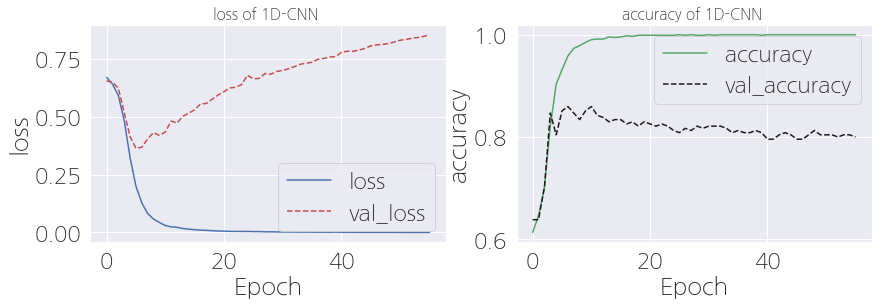

In [52]:
# # 모델 학습 결과 확인
# plt.figure(figsize=(14, 4))

# plt.subplot(1, 2, 1)
# plt.title('loss of 1D-CNN ', fontsize= 15)
# plt.plot(history4.history['loss'], 'b-', label='loss')
# plt.plot(history4.history['val_loss'],'r--', label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.title('accuracy of 1D-CNN ', fontsize= 15)
# plt.plot(history4.history['accuracy'], 'g-', label='accuracy')
# plt.plot(history4.history['val_accuracy'],'k--', label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show
# plt.savefig('1D-CNN.png')

In [14]:
func('에스케이이노베이션')

'에스케이이노베이션'